# Open World Classification

In this notebook, we explore the challenges of deploying AI models in real-world scenarios, where models often encounter **unseen or unknown data**.

We start by developing a **Convolutional Neural Network (CNN)** to classify images of **bikes and cars**. Once trained, we will expose the model to **`unknown`** images, representing inputs outside the training distribution, to evaluate its behavior.

To address this **open-world classification problem**, we implement and compare two approaches for handling unknown inputs:

1. **OpenMax** – a method that recalibrates class probabilities based on the distance of features to class-specific activation vectors.
2. **Energy-based OOD detection** – a technique that leverages the energy of model logits to identify out-of-distribution samples.

This notebook aims to demonstrate both the limitations of standard softmax-based classifiers in open-world settings and practical methods to improve robustness to unknown data.


In [1]:
import pandas as pd
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import typing as t
import tensorflow as tf
import numpy as np

# Check if CUDA is successfully installed.
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)
        
print("TensorFlow version:", tf.__version__)
print("GPU available :", tf.config.list_physical_devices('GPU'))

2025-10-07 14:19:06.593832: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-07 14:19:06.630611: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-07 14:19:07.419190: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


TensorFlow version: 2.20.0
GPU available : [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# I - Metdata oversight

> build a metadata dataframe containing labels and path to images

In [2]:
dataset_dir = Path().cwd().joinpath("Car-Bike-Dataset")
labels = []
image_path = []
for category in dataset_dir.iterdir():
    if category.is_dir() == True and category.name not in ["data_split"]:
        for filename in category.iterdir():
                # to str because tensorflow doesn't handle PosixPath
                if filename.name not in []:
                    labels.append(category.name)

                    image_path.append(str(filename))

metadata = pd.DataFrame({"filenames":image_path, "labels":labels})
metadata.to_csv(dataset_dir.joinpath("bike_vs_car.csv"))
metadata.sample(frac=1, random_state=28).head()

,filenames,labels
1544,/home/arnaud/Devs/BikeVsCar_Classification/Car...,Bike
125,/home/arnaud/Devs/BikeVsCar_Classification/Car...,Bike
376,/home/arnaud/Devs/BikeVsCar_Classification/Car...,Bike
1141,/home/arnaud/Devs/BikeVsCar_Classification/Car...,Bike
2734,/home/arnaud/Devs/BikeVsCar_Classification/Car...,Car


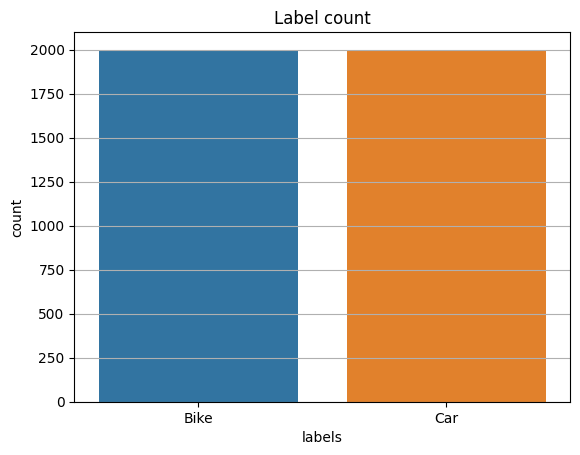

In [3]:
def plot_label_distribution(
    metadata_df: pd.DataFrame,
    label_column: str = "labels",
    title: str = "Label count",
    y_lim: t.Optional[t.Tuple[int, int]] = None,
):
    """Plot the label distribution as barplots.

    Args:
        metadata (pd.DataFrame): The metadata dataframe.
        label_column (str, optional): name of the label column.
            Defaults to "label".
        title (str, optional): Title of the figure. Defaults to "label count"
        y_lim (tuple, optional): y_lim tuple. See matplotlib docs.
            Defaults to None.

    """
    label_distribution = pd.DataFrame(
        metadata_df[label_column].value_counts()
    ).reset_index()

    plt.title(title)
    plt.grid()
    sns.barplot(label_distribution, x=label_column, y="count", hue=label_column)
    if y_lim:
        plt.ylim(y_lim)
    plt.show()


plot_label_distribution(metadata_df=metadata)

> *how lucky we have a balanced dataset !*

# II - Dataset processing

## a. Split the dataset into Train, valid and test split
- train split: data to train the model
- valid split: data to supervise model training.
- test split: data split to evaluate model performance.

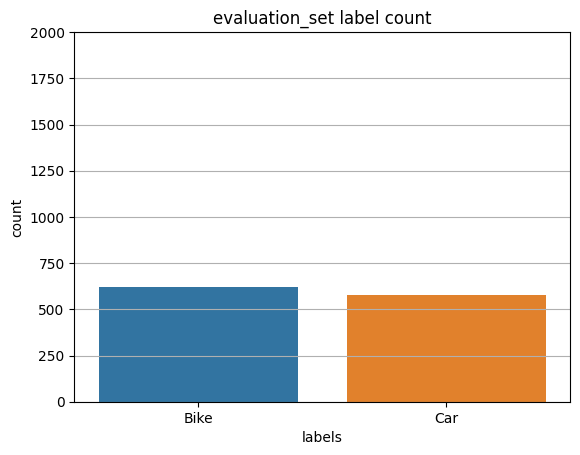

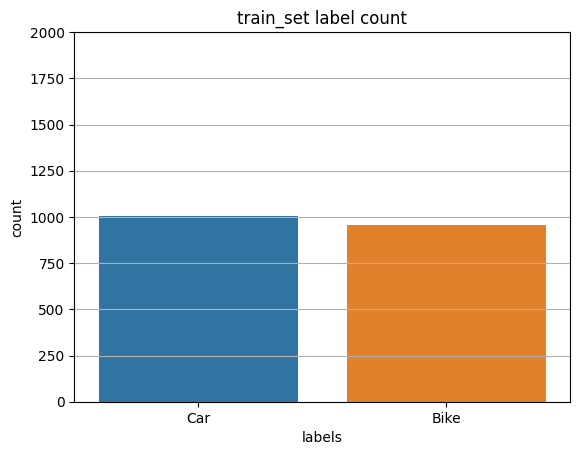

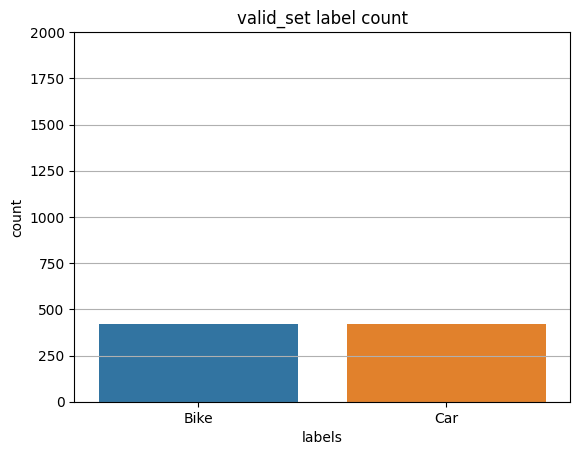

In [4]:
# Dataset to Train-valid and Eval set
# - Split en train (70%), eval (30%)
X_train_valid, X_eval, y_train_valid, y_eval = (
    sklearn.model_selection.train_test_split(
        metadata["filenames"],
        metadata["labels"],
        test_size=0.3,
        random_state=42,
    )
)

EVALUATION_SET = pd.concat([X_eval, y_eval], axis=1)


y_lim = (0, 2000)
plot_label_distribution(
    metadata_df=EVALUATION_SET,
    label_column="labels",
    title="evaluation_set label count",
    y_lim=y_lim,
)

train_valid_set = pd.concat([X_train_valid, y_train_valid], axis=1)

# Dataset to Train and valid set
# - Split en train (70%), valid (30%)
X_train, X_val, y_train, y_val = sklearn.model_selection.train_test_split(
    train_valid_set["filenames"],
    train_valid_set["labels"],
    test_size=0.3,
    random_state=42,
)


TRAIN_SET = pd.concat([X_train, y_train], axis=1)
VALID_SET = pd.concat([X_val, y_val], axis=1)


plot_label_distribution(
    metadata_df=TRAIN_SET,
    label_column="labels",
    title="train_set label count",
    y_lim=y_lim,
)
plot_label_distribution(
    metadata_df=VALID_SET,
    label_column="labels",
    title="valid_set label count",
    y_lim=y_lim,
)

In [5]:
# Serialize our split to .csv file.
dataset_split_dir = dataset_dir.joinpath("data_split")
dataset_split_dir.mkdir(exist_ok=True)
SPLIT_DICT = {"EVALUATION_SET" : EVALUATION_SET, "TRAIN_SET":TRAIN_SET, "VALID_SET": VALID_SET}
for split_name, split_df in SPLIT_DICT.items():
    split_df.to_csv(dataset_split_dir.joinpath(split_name).with_suffix(".csv"))
EVALUATION_SET.sample(frac=1).head()

,filenames,labels
2778,/home/arnaud/Devs/BikeVsCar_Classification/Car...,Car
1091,/home/arnaud/Devs/BikeVsCar_Classification/Car...,Bike
3661,/home/arnaud/Devs/BikeVsCar_Classification/Car...,Car
2252,/home/arnaud/Devs/BikeVsCar_Classification/Car...,Car
2287,/home/arnaud/Devs/BikeVsCar_Classification/Car...,Car


## Build a tensorflow dataset

In [6]:
CLASSES = ["Bike", "Car"]
IMG_SHAPE = [225, 224]

In [7]:
label_to_index = tf.lookup.KeyValueTensorInitializer(
    keys=tf.constant(CLASSES),
    values=tf.constant(list(range(len(CLASSES))), dtype=tf.int64),
)
label_to_index = tf.lookup.StaticHashTable(label_to_index, default_value=-1)


def one_hot_encode(
    features: np.ndarray, label: str, num_classes=len(CLASSES)
) -> t.Tuple[tf.Tensor, tf.Tensor]:
    """Encode label to one hot encoded vector.

    Args:
        features (np.ndarray): Features array ```(here it is image matrix)```.
        label (str): The label name.
        num_classes (_type_, optional): The number of classes.
            Defaults to len(CLASSES).

    Returns:
        Tuple[tf.Tensor, tf.Tensor]: A 2-Tuple containing features and the one
        hot label vector.

    Note:
        - Features are not processed in this function.
        - This function is designed to work with the tf.data.Dataset.map() method.

    """
    label_encoded = label_to_index.lookup(label)  # string to integer
    one_hot = tf.one_hot(label_encoded, num_classes)  # int to one hot vector
    return features, one_hot


def load_image(
    path_to_image: str, label: t.Optional[str] = None
) -> t.Tuple[tf.Tensor, tf.Tensor]:
    """Load and process image.

    Args:
        path_to_image (str): Path to image.
        label (t.Optional[str], optional): Label name. Defaults to None.

    Returns:
        Tuple[tf.Tensor, tf.Tensor]: A 2-Tuple containing features and the one
            hot label vector.
    """
    img = tf.io.read_file(path_to_image)
    img = tf.image.decode_image(img, channels=3, expand_animations=False)  # rgb image
    img = tf.image.resize_with_pad(img, 224, 224)  # 256x256 image

    img = img / 255.0  # Normalize [0,1]
    if len(img.shape) > 3:
        raise ValueError(
            f"found invalid image at {path_to_image} with shape {img.shape}"
        )
    return img, label


def build_image_dataset(
    metadata_df: pd.DataFrame, batch_size: int = 16
) -> tf.data.Dataset:
    """Build image dataset.

    Compute a image dataset with the given dataframe:
    - load and process images.
    - encode label to one hot vectors.

    Args:
        metadata_df (pd.DataFrame): A metadata dataframe.

    Returns:
        tf.data.Dataset: A tensorflow dataset containing images and labels.

    """
    tf_dataset = tf.data.Dataset.from_tensor_slices(
        (
            metadata_df["filenames"],
            metadata_df["labels"],
        )
    )
    tf_dataset = tf_dataset.map(load_image)
    tf_dataset = tf_dataset.map(one_hot_encode)
    return tf_dataset.batch(16).cache().prefetch(buffer_size=tf.data.AUTOTUNE)


# Render dataset for each data split.
tf_eval_dataset = build_image_dataset(EVALUATION_SET)
tf_train_dataset = build_image_dataset(TRAIN_SET)
tf_valid_dataset = build_image_dataset(VALID_SET)

I0000 00:00:1759839548.365525   23958 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3883 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1660 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5


# III. Model training
We will use the ResNet50 as base model and fine-tune it to our case study.

In [8]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models


# Load pretrained ResNet50
base_model = ResNet50(
    weights="imagenet", include_top=False, input_shape=(224,224, 3)
)
base_model.trainable = True

bike_classifier = models.Sequential(
    [
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation="relu", name="embeddings"),
        layers.Dense(
            len(CLASSES), activation="softmax"
        ),
    ]
)

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)


bike_classifier.compile(
    optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
)

> Define callbacks

In [9]:
from tensorflow.keras.callbacks import (
    EarlyStopping,
    TensorBoard,
    # ModelCheckpoint,
    # ReduceLROnPlateau,
)
import datetime

early_stop = EarlyStopping(
    monitor="val_loss", patience=5, restore_best_weights=True
)

# tensorboard settings
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(
    log_dir=log_dir, histogram_freq=1, update_freq="epoch"
)

CALLBACKS = [tensorboard_callback, early_stop]

> **Train model**
<br>*(install cuda to use GPU for faster training)*

In [10]:
history_finetune = bike_classifier.fit(
    tf_train_dataset,
    validation_data=tf_valid_dataset,
    epochs=16,
    callbacks=CALLBACKS,
    # batch_size=16,

)

Epoch 1/16


2025-10-07 14:19:23.668511: I external/local_xla/xla/service/service.cc:163] XLA service 0x7058e0004000 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-10-07 14:19:23.668545: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce GTX 1660 Ti, Compute Capability 7.5
2025-10-07 14:19:24.132114: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-10-07 14:19:26.672093: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91002
2025-10-07 14:19:27.699389: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:546] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[16,64,56,56]{3,2,1,0}, u8[0]{0}) custom-call(f32[16,64,56,56]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_cal

122/123 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - accuracy: 0.8540 - loss: 0.3486

2025-10-07 14:20:04.791162: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:546] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[8,64,56,56]{3,2,1,0}, u8[0]{0}) custom-call(f32[8,64,56,56]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false,"reification_cost":[]}
2025-10-07 14:20:04.977639: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:546] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[8,128,28,28]{3,2,1,0}, u8[0]{0}) custom-call(f32[8,128,28,28]{3,2,1,0}, f32[128,128,3,3]{3,2,1,0}, f32[128]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__

123/123 ━━━━━━━━━━━━━━━━━━━━ 73s 363ms/step - accuracy: 0.9362 - loss: 0.1962 - val_accuracy: 0.4976 - val_loss: 0.8351
Epoch 2/16
123/123 ━━━━━━━━━━━━━━━━━━━━ 26s 214ms/step - accuracy: 0.9969 - loss: 0.0221 - val_accuracy: 0.5060 - val_loss: 0.7991
Epoch 3/16
123/123 ━━━━━━━━━━━━━━━━━━━━ 26s 212ms/step - accuracy: 1.0000 - loss: 0.0071 - val_accuracy: 0.5917 - val_loss: 0.7030
Epoch 4/16
123/123 ━━━━━━━━━━━━━━━━━━━━ 26s 215ms/step - accuracy: 1.0000 - loss: 0.0037 - val_accuracy: 0.7560 - val_loss: 0.4557
Epoch 5/16
123/123 ━━━━━━━━━━━━━━━━━━━━ 26s 215ms/step - accuracy: 1.0000 - loss: 0.0024 - val_accuracy: 0.9250 - val_loss: 0.1951
Epoch 6/16
123/123 ━━━━━━━━━━━━━━━━━━━━ 26s 214ms/step - accuracy: 1.0000 - loss: 0.0016 - val_accuracy: 0.9738 - val_loss: 0.0821
Epoch 7/16
123/123 ━━━━━━━━━━━━━━━━━━━━ 26s 214ms/step - accuracy: 1.0000 - loss: 0.0012 - val_accuracy: 0.9857 - val_loss: 0.0444
Epoch 8/16
123/123 ━━━━━━━━━━━━━━━━━━━━ 26s 215ms/step - accuracy: 1.0000 - loss: 8.9975e-04 -

# IV - Evaluate

In [11]:
predictions = bike_classifier.predict(tf_eval_dataset)

75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step


> *Render `y_true` and `y_pred`* for evalutation

In [12]:
# Binarize prediction to simplify evaluation 
y_pred = (predictions > 0.5).astype(int)  
y_pred

y_true = np.concatenate([y for x, y in tf_eval_dataset], axis=0)
y_true

2025-10-07 14:26:37.418259: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


array([[1., 0.],
       [0., 1.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [0., 1.]], shape=(1200, 2), dtype=float32)

> **Model performance**

In [13]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
)

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(
    y_true, y_pred, average="macro"
)  # 'micro' ou 'weighted' selon le besoin
recall = recall_score(y_true, y_pred, average="macro")
f1 = f1_score(y_true, y_pred, average="macro")

print("\t MODEL PERFORMANCE")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

	 MODEL PERFORMANCE
Accuracy: 0.9875
Precision: 0.9874
Recall: 0.9876
F1-score: 0.9875


> **Confusion matrix**

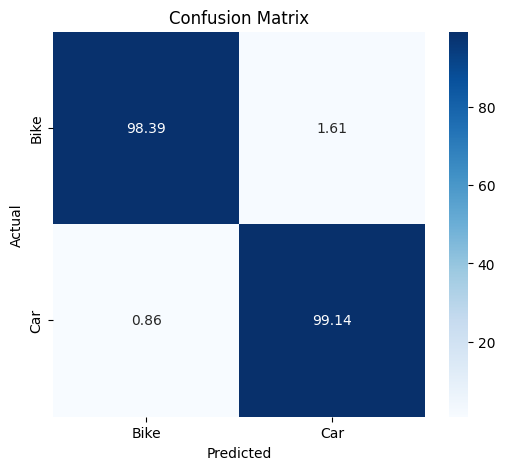

,Predicted Bike,Predicted Car
Actual Bike,98.392,1.608
Actual Car,0.865,99.135


In [14]:
from sklearn.metrics import confusion_matrix
import pandas as pd

label_to_index = {label: i for i, label in enumerate(CLASSES)}
index_to_label = {v: k for k, v in label_to_index.items()}  # int -> string


def one_hot_decode(one_hot: tf.Tensor, index_to_label: t.Dict[int, str]=index_to_label) -> str:
    """Convert one hot vector to string label.

    Args:
        one_hot (tf.Tensor): One hot label vector.
        index_to_label: Dictionary mapping integer to string.

    Returns:
        str: String label name
    """
    class_index = tf.argmax(one_hot).numpy()  # récupérer l'indice
    label = index_to_label[class_index]  # convertir en string
    return label


def display_confusion_matrix(
    y_true: t.List[str],
    y_pred: t.List[str],
    labels: t.Optional[t.List[str]] = None,
):
    """
    Display a confusion matrix in a readable table format.

    Args:
        y_true (List[str]): True class labels.
        y_pred (List[str]): Predicted class labels.
        labels (List[str]): List of class labels to index the matrix.
            Defaults to None.
            
    """
    # Compute the confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm = np.round(cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] * 100, 3)

    # Use labels for rows and columns if provided
    if labels is None:
        labels = sorted(list(set(y_true) | set(y_pred)))

    # Create a DataFrame for nice display
    cm_df = pd.DataFrame(
        cm,
        index=[f"Actual {l}" for l in labels],
        columns=[f"Predicted {l}" for l in labels],
    )

    # Create the heatmap
    plt.figure(figsize=(6, 5))
    sns.heatmap(
        cm,
        annot=True,
        fmt=".2f",
        xticklabels=labels,
        yticklabels=labels,
        cmap="Blues",
    )

    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.title("Confusion Matrix")
    plt.show()
    return cm_df


y_true_str = [one_hot_decode(i) for i in y_true]
y_pred_str = [one_hot_decode(i) for i in y_pred]
display_confusion_matrix(y_true_str, y_pred_str, labels=CLASSES)

In [15]:
from PIL import Image
import io
import requests

def predict_on_file(
    model: tf.keras.Model,
    image_path: t.Optional[Path] = None,
    image_url: t.Optional[str] = None,
)->np.ndarray:
    """Predict on file.
    
    Compute model prediction on image (stored on disk or with url link).

    Args:
        model (tf.keras.Model): keras model.
        image_path (t.Optional[Path], optional): Path to image.
            Defaults to None.
        image_url (t.Optional[str], optional): Url of the image.
            Defaults to None.

    Returns:
        np.ndarray: The prediction array.
        
    """

    feature = None
    if image_path:
        feature, _ = load_image(str(image_path))
        
    if image_url:
        response = requests.get(image_url)
        feature = Image.open(io.BytesIO(response.content))

        feature = np.array(feature)
        feature = tf.image.resize(feature, [224, 224])  # 256x256 image
        feature = feature / 255.0  # Normalize [0,1]

    feature = np.reshape(feature, (-1, 224, 224, 3))
    proba = model.predict(feature)
    return feature, proba


2025-10-07 14:26:39.332992: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:546] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[1,128,28,28]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,128,28,28]{3,2,1,0}, f32[128,128,3,3]{3,2,1,0}, f32[128]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false,"reification_cost":[]}
2025-10-07 14:26:39.492392: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:546] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[1,256,14,14]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,256,14,14]{3,2,1,0}, f32[256,256,3,3]{3,2,1,0}, f32[256]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_targe

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


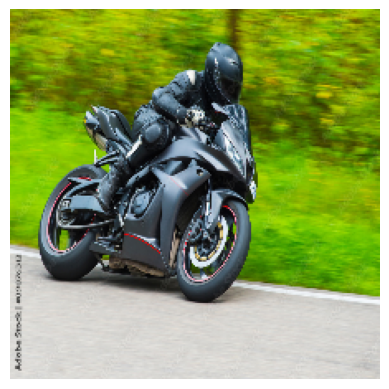

['99.87%', '0.13%'] Bike


,Bike,Car
0,99.870697,0.129301


In [16]:
true_bike_image_url = "https://as2.ftcdn.net/v2/jpg/00/89/07/63/1000_F_89076312_sbxXwcGITdbVARuWd4PNsyMVvtBazKYi.jpg"

img, preds = predict_on_file(
    model=bike_classifier,
    image_url=true_bike_image_url
)
preds
# Exemple : features = np.random.rand(224,224,3)
plt.imshow(img[0])
plt.axis('off')  # cacher les axes
plt.show()


label_str = one_hot_decode(one_hot=preds[0])

arr_percent = preds * 100
preds_df = pd.DataFrame(arr_percent, columns=CLASSES)
# print(preds_df)


formatted = ["{:.2f}%".format(x) for x in arr_percent[0]]
print(formatted, label_str)
preds_df


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


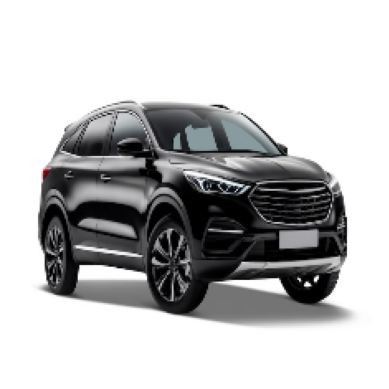

['0.01%', '99.99%'] Car


,Bike,Car
0,0.011702,99.988297


In [17]:
true_car_img_url = "https://img.freepik.com/psd-gratuit/voiture-isolee-noire_23-2151852894.jpg?semt=ais_hybrid&w=740&q=80"
img, preds = predict_on_file(
    model=bike_classifier,
    image_url=true_car_img_url
)
preds
# Exemple : features = np.random.rand(224,224,3)
plt.imshow(img[0])
plt.axis('off')  # cacher les axes
plt.show()


label_str = one_hot_decode(one_hot=preds[0])

arr_percent = preds * 100
preds_df = pd.DataFrame(arr_percent, columns=CLASSES)
# print(preds_df)


formatted = ["{:.2f}%".format(x) for x in arr_percent[0]]
print(formatted, label_str)
preds_df


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


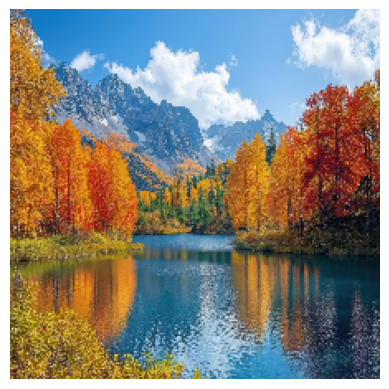

['76.39%', '23.61%'] Bike


,Bike,Car
0,76.391785,23.608217


In [18]:
out_of_distribution_img_url = "https://i0.wp.com/picjumbo.com/wp-content/uploads/beautiful-fall-nature-scenery-free-image.jpeg?w=2210&quality=70"
img, preds = predict_on_file(
    model=bike_classifier,
    image_url=out_of_distribution_img_url
)
preds
# Exemple : features = np.random.rand(224,224,3)
plt.imshow(img[0])
plt.axis('off')  # cacher les axes
plt.show()


label_str = one_hot_decode(one_hot=preds[0])

arr_percent = preds * 100
preds_df = pd.DataFrame(arr_percent, columns=CLASSES)
# print(preds_df)


formatted = ["{:.2f}%".format(x) for x in arr_percent[0]]
print(formatted, label_str)
preds_df


Although our model demonstrates strong theoretical performance, it struggles with **unknown inputs**. When presented with an image that is **neither a bike nor a car**, the predicted probabilities can still be high. This makes it difficult to set a simple threshold for detecting outliers.  

For example, with a threshold of **probability > 0.5**, this image would incorrectly be classified as a **bike**!


# VI - Outliers Detection

In this section, we will explore two different methods to detect outliers in model predictions.

***Note**: This approach took significant effort to develop. I am not sharing it publicly, but feel free to contact me for more details.*

## 1. OpenMax

**OpenMax** is an extension of the traditional softmax layer designed to handle **open set recognition** problems.  
Instead of forcing every sample to belong to one of the known classes, OpenMax introduces the concept of **unknown classes** by modeling the distribution of activation vectors from the penultimate layer.

**Key ideas:**
- Compute class-wise mean activation vectors (MAVs) from training data.
- Fit a Weibull distribution to the tail of distances between activation vectors and their MAVs.
- Adjust the softmax probabilities to include an “unknown” probability, allowing detection of out-of-distribution (OOD) or novel samples.

**Advantages:**
- Better handles unknown or unseen classes.
- Reduces overconfidence on out-of-distribution inputs.

---

## 2. OOD (Out-of-Distribution) Detection

OOD detection methods aim to identify samples that come from a **different distribution** than the one the model was trained on.  
These approaches typically rely on uncertainty estimation or statistical differences in feature representations.

**Common strategies:**
- **Softmax thresholding:** classify samples with low confidence as outliers.  
- **Feature-based distances:** measure how far a sample’s representation is from the known feature space (e.g., Mahalanobis distance).  
- **Energy-based or score-based methods:** compute an energy score from logits to quantify uncertainty.

**Goal:**
Improve model robustness by flagging or rejecting samples that do not belong to the training distribution.

---

Both **OpenMax** and **OOD detection** aim to make deep models more reliable by identifying when a prediction may not be trustworthy.


## OpenMaxEstimator

First, we will **freeze** the TensorFlow model graph and convert it to the **ONNX** format.  
This conversion improves inference efficiency and makes it easier to **access intermediate layers**,  
which are essential for extracting feature activation vectors.


In [19]:
# Make sure your model is built
input_shape = (1, 224, 224, 3)  # batch size 1, change H,W,C to your model

# Call the model once to build it
dummy_input = np.zeros(input_shape, dtype=np.float32)
_ = bike_classifier(dummy_input)

bike_classifier.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embeddings (Dense)              │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 72,232,072 (275.54 MB)

 Trainable params: 24,059,650 (91.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

 Optimizer params: 48,119,302 (183.56 MB)

In [20]:
from tensorflow.python.framework.convert_to_constants import (
    convert_variables_to_constants_v2,
)
import keras


def freeze_graph(
    classifier: keras.Model, model_save_name: str = "frozen_graph.pb"
):
    """Freeze model graph

    Args:
        classifier (keras.Model): Keras classifier.
        model_save_name (str, optional): Model save name.
            Defaults to "frozen_graph.pb".

    """
    full_model = tf.function(lambda x: classifier(x))

    concrete_func = full_model.get_concrete_function(
        tf.TensorSpec(classifier.inputs[0].shape, classifier.inputs[0].dtype)
    )

    frozen_func = convert_variables_to_constants_v2(concrete_func)
    frozen_graph_def = frozen_func.graph.as_graph_def()

    # Serialize graph
    tf.io.write_graph(frozen_graph_def, "", model_save_name, as_text=False)


freeze_graph(bike_classifier, model_save_name="frozen_bike_model.pb")

Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'NoneType' object has no attribute 'name'


I0000 00:00:1759840001.750186   23958 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
I0000 00:00:1759840001.750257   23958 single_machine.cc:376] Starting new session
I0000 00:00:1759840001.753216   23958 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3883 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1660 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5


> Convert frozen graph to ONNX with `tf2onnx` in CLI.  
> This should look like something like:

```bash
python -m tf2onnx.convert \
    --graphdef frozen_bike_model.pb \
    --output model.onnx \
    --inputs x:0 \
    --outputs Identity:0 \
    --opset 13


In [21]:
from onnx_model_handler import describe_onnx_model_graph, make_intermediate_output

In [22]:
describe_onnx_model_graph(onnx_model_filename=Path("model.onnx"))
    

	'model.onnx' MODEL GRAPH

Inputs: ['x:0']
Outputs: ['Identity:0']


In [23]:
make_intermediate_output(
    original_onnx_model_filename="model.onnx",
    output_onnx_model_filename=Path("model_with_intermediate.onnx"),
    intermediate_tensor_name="sequential_1/embeddings_1/Relu",
)

Loading original model: 'model.onnx'
Added intermediate output to model at: 'model_with_intermediate.onnx'


In [24]:
describe_onnx_model_graph(Path("model_with_intermediate.onnx"))

	'model_with_intermediate.onnx' MODEL GRAPH

Inputs: ['x:0']
Outputs: ['Identity:0', 'sequential_1/embeddings_1/Relu:0']


In [25]:
import onnx
import onnxruntime as ort

onnx_model_with_intermediate_layers = onnx.load("model_with_intermediate.onnx")
# onnx.checker.check_model(onnx_model_with_intermediate_layers)

session_intermediate_ayers = ort.InferenceSession("model_with_intermediate.onnx")
features_activation_vectors = session_intermediate_ayers.run(['sequential_1/embeddings_1/Relu:0'], {"x:0": dummy_input})[0]

print("features_activation_vectors shape:")
features_activation_vectors.shape

features_activation_vectors shape:


(1, 256)

In [26]:
from outliers_detection import OpenMaxEstimator
import tqdm

> Initialize OpenMaxEstimator

In [27]:
open_bike_vs_car_model = OpenMaxEstimator(
    classes=CLASSES,
    onnx_model_filename="model_with_intermediate.onnx",
    intermediate_output="sequential_1/embeddings_1/Relu",
)


> Prepare train set to calibrate the `OpenMaxEstimator`.

In [28]:
all_features = []
for features,_ in tf_train_dataset.as_numpy_iterator():
    all_features.append(features)

y_train = np.concatenate([y for x, y in tf_train_dataset], axis=0)
y_train_true = np.array([one_hot_decode(y) for y in y_train])

all_features = np.vstack(all_features)
all_features.shape

2025-10-07 14:26:44.887051: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


(1960, 224, 224, 3)

### Calibrate Weibull Model

In this step, we calibrate a **Weibull distribution** for each class to model how activation vectors behave near the decision boundaries.
This calibration helps estimate how “typical” or “extreme” a new sample’s feature representation is compared to known training samples.

#### Process overview

1. **Compute the Mean Activation Vector (MAV)** for each class using correctly classified training samples.
2. **Measure distances** between each activation vector and its corresponding MAV.
3. **Select the tail** of the distance distribution — these represent the most extreme, less typical samples.
4. **Fit a Weibull model** to this tail to learn the shape and scale parameters for each class.
5. **Store the parameters** (MAV, Weibull shape, and scale) for use during infere

---
> Pseudo-code

```text
for each class c:
    V_c = [v_i for samples of class c]          # Extract activation vectors
    MAV_c = mean(V_c)                           # Compute Mean Activation Vector (MAV)
    D_c = [norm(v - MAV_c) for v in V_c]        # Compute distances to MAV
    tail = select_largest(D_c, tail_size)       # Select the largest distances (tail)
    (kappa_c, lambda_c) = fit_weibull(tail)     # Fit Weibull model to the tail
    save_params(c, MAV_c, kappa_c, lambda_c)    # Store parameters for inference

  


In [29]:
open_bike_vs_car_model.fit(all_features, y_train_true)

Compute features activation vectors: 100%|██████████| 1960/1960 [00:22<00:00, 85.70it/s]


### OOD Detection — Energy-Based Method

The **energy-based OOD detection** approach measures how confident a neural network is about its predictions using an *energy score* derived from the model’s logits (pre-softmax outputs).  
Unlike softmax probabilities, which can be overconfident even for out-of-distribution (OOD) samples, the energy score provides a more reliable uncertainty signal.

#### Core idea

- **In-distribution samples** tend to have **lower energy**, as their logits strongly align with known classes.  
- **OOD samples** tend to have **higher energy**, as their logits are less aligned with any known class.

#### Detection process

1. Compute the energy score for each input sample.  
2. Define a **threshold** based on validation data.  
3. Classify samples as:
   - **In-distribution** if the energy is below the threshold.  
   - **Out-of-distribution** if the energy is above the threshold.

#### Advantages

- Works directly from logits, no retraining needed.  
- More stable than softmax confidence for OOD detection.  
- Compatible with different architectures and tasks.

#### Practical tips

- Temperature scaling can improve the separation between in-distribution and OOD samples.  
- Often combined with input perturbation or feature normalization to enhance robustness.

---

This method provides a simple yet effective way to detect out-of-distribution samples using model outputs.


In [30]:
open_bike_vs_car_model.calibrate_ood_threshold()

-6.1711035


# VII - Open World classification

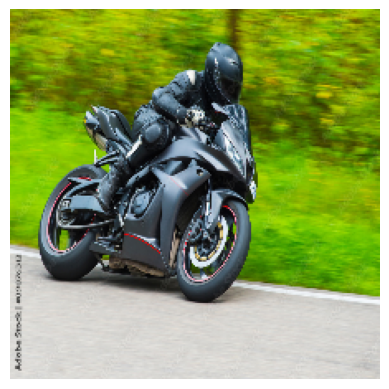

img shape (1, 224, 224, 3)
Energy scores: [-6.428083]
OOD flags: [False]


,Bike,Car,unknown
0,0.999851,1.235280e-08,0.000149


In [31]:
open_bike_vs_car_model.predict_on_file(image_url=true_bike_image_url)

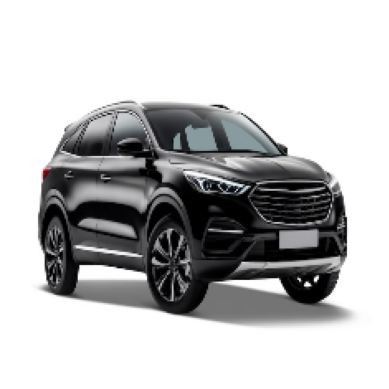

img shape (1, 224, 224, 3)
Energy scores: [-6.3567114]
OOD flags: [False]


,Bike,Car,unknown
0,1.270453e-09,0.999798,0.000202


In [32]:
open_bike_vs_car_model.predict_on_file(image_url=true_car_img_url)

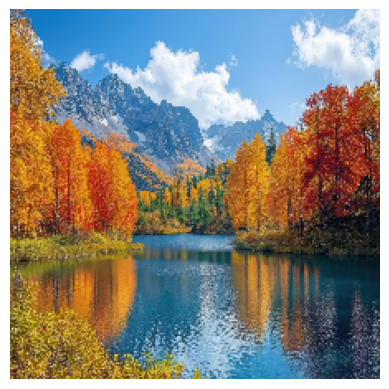

img shape (1, 224, 224, 3)
Energy scores: [-6.627979]
OOD flags: [False]


,Bike,Car,unknown
0,0.00731,0.004788,0.987902


In [33]:
open_bike_vs_car_model.predict_on_file(image_url=out_of_distribution_img_url)

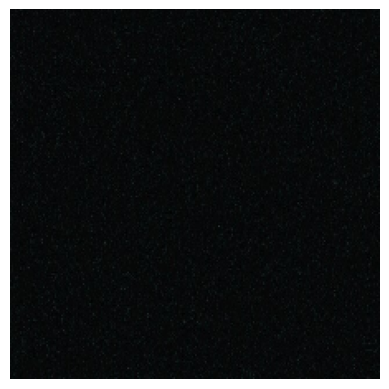

img shape (1, 224, 224, 3)
Energy scores: [-6.168559]
OOD flags: [ True]


,Bike,Car,unknown
0,0.127595,0.754447,0.117958


In [34]:
trigger_ood = "https://t4.ftcdn.net/jpg/04/21/44/29/360_F_421442912_e9dARIDF7CnBKKcB1Ooy0aNcEOJ13eVY.jpg"
open_bike_vs_car_model.predict_on_file(image_url=trigger_ood)